# Compare success of different lineages
Natalia Vélez, July 2020

Now that we've built a graph representation of family trees, we'll use it to compare lineages and operationalize a success measure.

In [1]:
%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj

import pandas as pd
import numpy as np
import scipy.stats
from tqdm import notebook

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

sns.set_context('talk')
sns.set_style('white')

## Set up data

Find start of boundless era from version history:

In [2]:
ver_history = pd.read_csv('../1_download/outputs/version_history.tsv', sep='\t')
boundless_t = ver_history.loc[ver_history['release'] == 280, 'timestamp'].values[0]
print('Start of boundless: %s' % datetime.datetime.fromtimestamp(boundless_t))
ver_history.head()

Start of boundless: 2019-11-08 22:27:14


,release,timestamp
0,1,1.483052e+09
1,5,1.483472e+09
2,8,1.484065e+09
3,14,1.484961e+09
4,16,1.492207e+09


Load lifelog data:

In [3]:
all_eras = pd.read_csv('outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
all_eras.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,06d8ab86b0daf11b13a446b87f770aa20bee1ca0,3308603,1599462917,3308581,[-63752 -504],NaN,[],NaN,NaN,-63752,-504,NaN,NaN,SUPERIOR,MATSU
1,67bffa53500e2c626edc407409b6550996b748db,3308602,1599462864,3308575,[-63753 -507],NaN,[],NaN,NaN,-63753,-507,NaN,NaN,FEATHER,MATSU
2,fbc0168048713cfaf6ef6a350c0171e7b2b0af4a,3308601,1599462805,3308564,[-63762 -523],NaN,[],NaN,NaN,-63762,-523,NaN,NaN,SASHA,MATSU
3,5d5050247e485d0224df4e392118c27b8ee3a88b,3308598,1599462667,3308575,[-63747 -498],NaN,[],NaN,NaN,-63747,-498,NaN,NaN,DRAGON,MATSU
4,310d12780dbb316a3b50f83adbf9ce76973172bb,3308597,1599462620,3308571,[-63756 -508],1.599464e+09,[-63841 -520],28.89,hunger,-63756,-508,-63841.0,-520.0,MODOU,MATSU


Load families & find families that started in boundless era:

In [4]:
fam_df = pd.read_csv('outputs/family_playerID.tsv', sep='\t', index_col=0)
fam_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,avatar,family
0,3308592,time-1599460982_eve-3308568_name-SOL
1,3308568,time-1599460982_eve-3308568_name-SOL
2,3308504,time-1599458188_eve-3308504_name-SOL
3,3308439,time-1599456178_eve-3308427_name-MORALES
4,3308507,time-1599456178_eve-3308427_name-MORALES


Find families that started in boundless era:

In [5]:
in_boundless = fam_df.groupby('family')['avatar'].agg('count').reset_index()
in_boundless['start_t'] = in_boundless['family'].str.extract(r'(?<=time-)([0-9]+)')
in_boundless['start_t'] = in_boundless['start_t'].astype(np.int)
in_boundless['in_era'] = in_boundless['start_t'] > boundless_t
in_boundless = in_boundless[['family', 'in_era']]

# Summary: How many families left?
print('Total families: %i' % in_boundless.shape[0])
in_boundless.groupby('in_era')['family'].agg('count')

Total families: 59879


in_era
False    49880
True      9999
Name: family, dtype: int64

Merge:

In [6]:
print('Original size: %s' % str(all_eras.shape))
boundless_df = pd.merge(all_eras, fam_df, on='avatar')
boundless_df = pd.merge(boundless_df, in_boundless, on='family')
boundless_df = boundless_df[boundless_df['in_era']]
boundless_df = boundless_df.reset_index(drop=True)
print('Boundless era only: %s' % str(boundless_df.shape))

Original size: (1826661, 15)
Boundless era only: (477189, 17)


Remove singleton families:

In [7]:
singletons = boundless_df.groupby('family')['avatar'].agg('count').reset_index()
singletons = singletons.rename(columns={'avatar': 'count'})
singletons = singletons[singletons['count'] == 1]
single_fams = singletons.family.values

print('Removing %i singleton families' % len(single_fams))
boundless_df = boundless_df[~boundless_df['family'].isin(single_fams)]
#era_df = era_df.reset_index(drop=True)

Removing 5853 singleton families


New! Exclude infant births:

In [8]:
orig_n = len(boundless_df)
infant_deaths = np.loadtxt('outputs/infant_deaths.txt', dtype=np.int)
boundless_df = boundless_df[~boundless_df['avatar'].isin(infant_deaths)].reset_index(drop=True)
new_n = len(boundless_df)

print('Removed %i infant deaths' % (orig_n - new_n))

Removed 28557 infant deaths


Just look at lineages from the boundless world era:

In [9]:
boundless_families = np.unique(boundless_df['family'])

print('Analyzing %i families' % len(boundless_families))
print('%i avatars' % len(np.unique(boundless_df['avatar'])))
print('%i unique players' % len(np.unique(boundless_df['player'])))

Analyzing 4146 families
442779 avatars
24519 unique players


Lives per player in current sample:

Median # lives: 4.00
Mean # lives: 18.06
Min # lives: 1
Max # lives: 1356


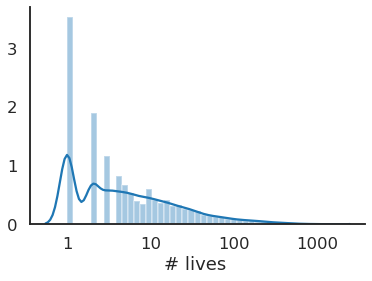

In [10]:
lineage_df = boundless_df.copy()
player_summ = lineage_df.groupby('player')['avatar'].agg('count').reset_index()
player_summ = player_summ.rename(columns={'avatar': 'n'})
player_summ.head()

# Plot
print('Median # lives: %0.2f' % np.median(player_summ['n']))
print('Mean # lives: %0.2f' % np.mean(player_summ['n']))
print('Min # lives: %i' % np.min(player_summ['n']))
print('Max # lives: %i' % np.max(player_summ['n']))

fig,ax = plt.subplots()
sns.distplot(np.log10(player_summ['n']),ax=ax)
ax.set(xlabel='# lives ', xticks=range(4), xticklabels=[10**x for x in range(4)])
sns.despine()

Start and end times:

In [12]:
t_fmt = '%Y-%m-%dT%H:%M:%S %Z'

start_t = np.min(lineage_df['tBirth'])
start_date = datetime.datetime.fromtimestamp(start_t).strftime(t_fmt)

end_t = np.max(lineage_df['tDeath'])
end_date = datetime.datetime.fromtimestamp(end_t).strftime(t_fmt)

print('Analyzing %i lineages' % len(boundless_families))
print('First lineage starts at: %s' % start_date)
print('Lineages end at: %s' % end_date)

Analyzing 4146 lineages
First lineage starts at: 2019-11-08T22:54:39 
Lineages end at: 2020-09-07T07:55:27 


What is the longest-lived lineage?

In [13]:
family_t = lineage_df.groupby('family').agg({'tBirth': 'min', 'tDeath': 'max'}).reset_index()
family_t['duration_hours'] = (family_t['tDeath'] - family_t['tBirth'])/60/60
family_t['duration_days'] = family_t['duration_hours']/24
family_t = family_t.sort_values(by='duration_hours', ascending=False).reset_index(drop=True)
family_t.head()

,family,tBirth,tDeath,duration_hours,duration_days
0,time-1579810712_eve-2612994_name-BOOTS,1579810712,1.580181e+09,102.945000,4.289375
1,time-1582959703_eve-2742223_name-BELLUE,1582959703,1.583327e+09,102.084167,4.253507
2,time-1584155688_eve-2783193_name-JESUS,1584155688,1.584521e+09,101.604167,4.233507
3,time-1592901881_eve-3098263_name-BATMAN,1592901881,1.593241e+09,94.142778,3.922616
4,time-1581646981_eve-2692838_name-VOLTAIRE,1581646981,1.581945e+09,82.882778,3.453449


## Compute summary statistics

### Family size and life expectancy

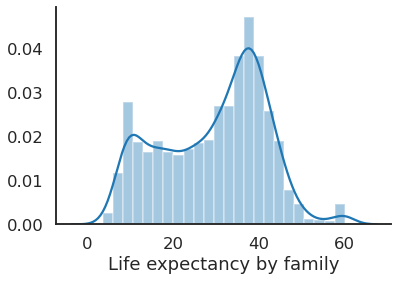

In [14]:
life_expectancy = lineage_df.groupby('family')['age'].agg(['mean', 'count']).reset_index()
ax = sns.distplot(life_expectancy['mean'])
ax.set(xlabel = 'Life expectancy by family')
sns.despine()

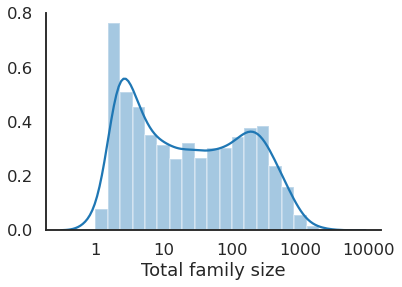

In [15]:
ax = sns.distplot(np.log10(life_expectancy['count']))
ax.set(xlabel = 'Total family size', xticks=range(5), xticklabels=[10**i for i in range(5)])
sns.despine()

In [16]:
scipy.stats.mode(life_expectancy['count'])

ModeResult(mode=array([2]), count=array([575]))

### Living population size over time

In [17]:
living_list = []
for fam in notebook.tqdm(boundless_families):
    fam_df = lineage_df[lineage_df['family'] == fam].copy().reset_index(drop=True)
    t = fam_df['tBirth'].values
    for ti in t:
        is_alive = (fam_df['tBirth'] <= ti) & (fam_df['tDeath'] > ti)
        pop = np.sum(is_alive)
        living_list.append((fam, ti, pop))

In [18]:
living_df = pd.DataFrame(living_list, columns = ['family', 't', 'population'])
living_df = living_df.sort_values(by=['family', 't'], ascending=True).reset_index(drop=True)
living_df['t0'] = living_df.groupby('family')['t'].transform('first')
living_df['t_elapsed'] = (living_df['t'] - living_df['t0'])/60/60
living_df.head()

,family,t,population,t0,t_elapsed
0,time-1573253679_eve-2251043_name-MCCRACKEN,1573253679,1,1573253679,0.000000
1,time-1573253679_eve-2251043_name-MCCRACKEN,1573253683,2,1573253679,0.001111
2,time-1573253679_eve-2251043_name-MCCRACKEN,1573253829,3,1573253679,0.041667
3,time-1573253679_eve-2251043_name-MCCRACKEN,1573254047,4,1573253679,0.102222
4,time-1573253679_eve-2251043_name-MCCRACKEN,1573254054,5,1573253679,0.104167


Plot a subset

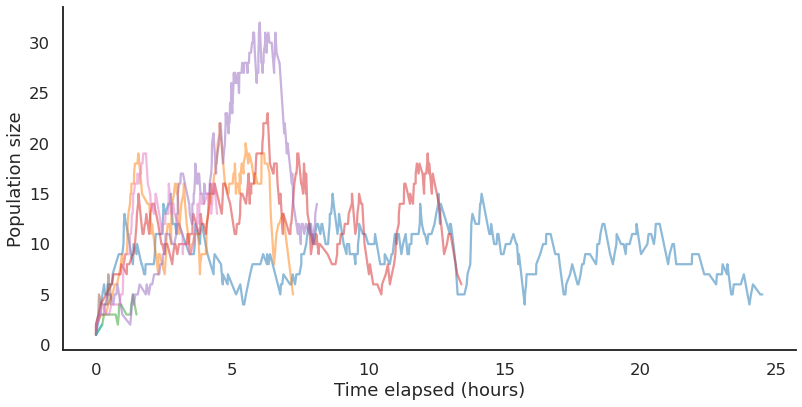

In [19]:
np.random.seed(526)
random_families = np.random.choice(boundless_families, size=10, replace=False)
random_subset = living_df[living_df['family'].isin(random_families)]
g = sns.relplot(data=random_subset, x='t_elapsed', y='population', hue='family', kind='line',
                 height=6, aspect=2, alpha = 0.5)
g.set(xlabel = 'Time elapsed (hours)', ylabel = 'Population size')
g._legend.remove()

Maximum population size

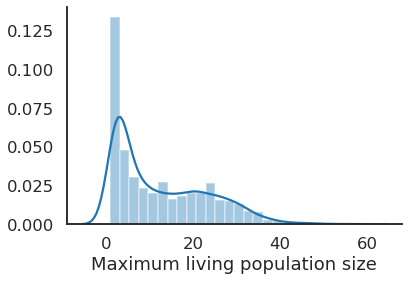

In [20]:
max_pop = living_df.groupby('family')['population'].agg('max').reset_index()
ax = sns.distplot(max_pop['population'])
ax.set(xlabel = 'Maximum living population size')
sns.despine()

In [21]:
scipy.stats.mode(max_pop['population'])

ModeResult(mode=array([2]), count=array([678]))

### Chain length

Helper: Read JSON files

In [22]:
def open_graph(f):
    with open(f) as handle:
        graph_data = json.load(handle)
    return nx.json_graph.node_link_graph(graph_data)

Find longest chain in family graphs

In [25]:
chain_list = []
family_generations = []

for f in notebook.tqdm(boundless_families):
    fam_file = 'outputs/families/families_%s.json' % f
    fam_graph = open_graph(fam_file)
    fam_chain = nx.algorithms.dag_longest_path(fam_graph)
    
    eve = re.search(r'(?<=eve-)([0-9]+)', f).group(0)
    
    chain_list.append((f, len(fam_chain)))

In [26]:
chain_df = pd.DataFrame(chain_list, columns=['family', 'chain'])
chain_df.head()

,family,chain
0,time-1573253679_eve-2251043_name-MCCRACKEN,3
1,time-1573253705_eve-2251049_name-FINCH,2
2,time-1573253707_eve-2251051_name-SORROWS,2
3,time-1573253710_eve-2251053_name-LION,4
4,time-1573253711_eve-2251054_name-DEADRICK,7


In [27]:
scipy.stats.mode(chain_df['chain'])

ModeResult(mode=array([2]), count=array([1278]))

[Text(0.5, 0, '# of generations')]

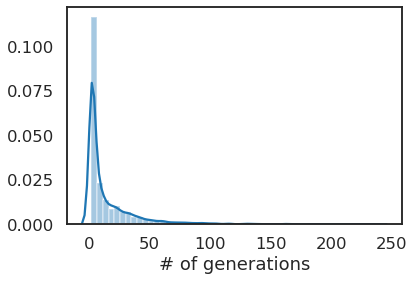

In [28]:
ax = sns.distplot(chain_df['chain'])
ax.set(xlabel = '# of generations')

In [29]:
chain_df.sort_values(by='chain', ascending=False).head()

,family,chain
1687,time-1584155688_eve-2783193_name-JESUS,238
1653,time-1582959703_eve-2742223_name-BELLUE,234
1585,time-1579810712_eve-2612994_name-BOOTS,234
3282,time-1592901881_eve-3098263_name-BATMAN,205
1582,time-1579512354_eve-2600506_name-MEGALE,187


## Modeling success

Criterion for "success": Reaching age 14 (viability fitness)

In [31]:
mortality_df = lineage_df.copy()
mortality_df['adult'] = (lineage_df['age'] >= 14)*1
mortality_df = mortality_df[['family', 'avatar', 'adult']]

mortality_summ = mortality_df.groupby('family')['adult'].agg(['sum', 'count']).reset_index()
mortality_summ['sum'] = mortality_summ['sum'].astype(np.int)
mortality_summ.head()

,family,sum,count
0,time-1573253679_eve-2251043_name-MCCRACKEN,2,9
1,time-1573253705_eve-2251049_name-FINCH,1,8
2,time-1573253707_eve-2251051_name-SORROWS,1,3
3,time-1573253710_eve-2251053_name-LION,9,40
4,time-1573253711_eve-2251054_name-DEADRICK,33,86


Compute beta distribution for each family

Prior: Uniform
$$
\theta \sim \mathrm{Beta}(\alpha_0, \beta_0) \\
\alpha_0 = \beta_0 = 1
$$

Posterior-sufficient statistics:
$$
\theta | D \sim \mathrm{Beta}(\alpha_0 + k, \beta_0 + N - k) \\ 
a = \alpha_0 + k \\
b = \beta_0 + N - k
$$

In [32]:
def beta_mean(row): return scipy.stats.beta.mean(row['a'], row['b'])
def beta_var(row): return scipy.stats.beta.var(row['a'], row['b'])

mortality_summ['a'] = 3 + mortality_summ['sum']
mortality_summ['b'] = 3 + mortality_summ['count'] - mortality_summ['sum']
mortality_summ['beta_mean'] = mortality_summ.apply(beta_mean, axis=1)
mortality_summ['beta_var'] = mortality_summ.apply(beta_var, axis=1)
mortality_summ['snr'] = mortality_summ['beta_mean']/mortality_summ['beta_var']
mortality_summ['weighted_size'] = mortality_summ['beta_mean']*mortality_summ['count']
mortality_summ.to_csv('outputs/family_fitness.tsv', sep='\t', index=False)
mortality_summ.head()

,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size
0,time-1573253679_eve-2251043_name-MCCRACKEN,2,9,5,10,0.333333,0.013889,24.000000,3.000000
1,time-1573253705_eve-2251049_name-FINCH,1,8,4,10,0.285714,0.013605,21.000000,2.285714
2,time-1573253707_eve-2251051_name-SORROWS,1,3,4,5,0.444444,0.024691,18.000000,1.333333
3,time-1573253710_eve-2251053_name-LION,9,40,12,34,0.260870,0.004102,63.588235,10.434783
4,time-1573253711_eve-2251054_name-DEADRICK,33,86,36,56,0.391304,0.002561,152.785714,33.652174


### Compare candidate success measures

Beta mean:

[Text(0.5, 0, 'Mean viability ($\\mu$)')]

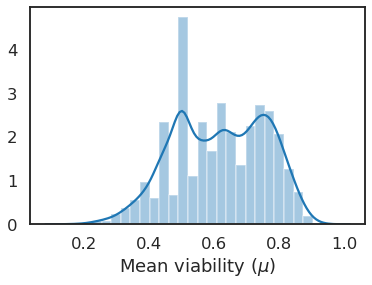

In [33]:
ax = sns.distplot(mortality_summ['beta_mean'])
ax.set(xlabel = 'Mean viability ($\mu$)')

Distribution of SNR:

[Text(0.5, 0, 'Signal-to-noise ratio ($\\mu/\\sigma$)')]

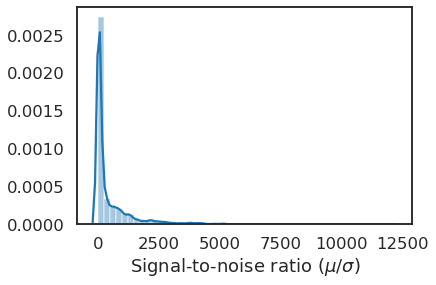

In [34]:
ax = sns.distplot(mortality_summ['snr'])
ax.set(xlabel='Signal-to-noise ratio ($\mu/\sigma$)')

Distribution of weighted size:

[Text(0.5, 0, 'Weighted family size ($\\mu N$)')]

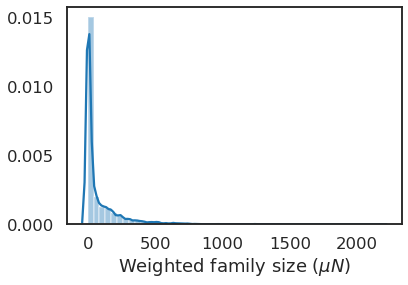

In [35]:
ax = sns.distplot(mortality_summ['weighted_size'])
ax.set(xlabel='Weighted family size ($\mu N$)')

Distribution of # adults:

[Text(0.5, 0, '# of adults')]

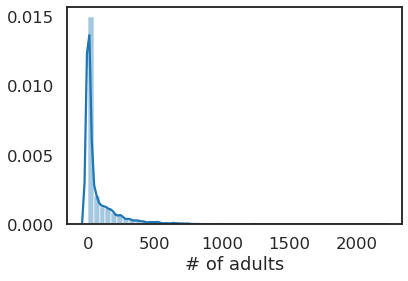

In [36]:
ax = sns.distplot(mortality_summ['sum'])
ax.set(xlabel='# of adults')

### Plot representative families

Split data into quartiles:

In [37]:
success = 'sum' # Success metric
mortality_summ['quantile'] = pd.qcut(mortality_summ[success], 4, labels=False)

What are the quantiles?

In [38]:
success_q = scipy.stats.mstats.mquantiles(mortality_summ[success], prob=[0.25, 0.5, 0.75, 1])
success_q

array([2.000e+00, 1.100e+01, 9.600e+01, 2.178e+03])

Plot representative family trees from each quartile:

In [41]:
np.random.seed(526)
representative_families = np.array([np.random.choice(group['family'], 10) 
                                    for name,group in mortality_summ.groupby('quantile')])
rep_list = np.array(representative_families)
rep_list = rep_list.flatten()

rep_info = mortality_summ.copy()
rep_info = rep_info[rep_info['family'].isin(rep_list)]
rep_info = rep_info.reset_index(drop=True)
rep_info = rep_info.sort_values('quantile')
rep_info.to_csv('plots/fitness_quantiles/selected_families.tsv', sep='\t', index=None)
rep_info.head()

,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,quantile
33,time-1592706571_eve-3091949_name-GODDEN,1,2,4,4,0.500000,0.027778,18.0,1.000000,0
32,time-1592220004_eve-3078168_name-LIPA,1,2,4,4,0.500000,0.027778,18.0,1.000000,0
37,time-1596602922_eve-3231679_name-WINCHESTER,2,4,5,5,0.500000,0.022727,22.0,2.000000,0
5,time-1576297110_eve-2409353_name-TWIST,1,3,4,5,0.444444,0.024691,18.0,1.333333,0
7,time-1577570402_eve-2482696_name-BEARSE,1,2,4,4,0.500000,0.027778,18.0,1.000000,0


In [42]:
for quant in notebook.tqdm(range(4)):
    for f in notebook.tqdm(representative_families[quant]):
        fam_file = 'outputs/families/families_%s.json' % f
        out_file = 'plots/fitness_quantiles/families_Q%i_%s.png' % (quant+1, f)

        # Chain length (for plot height)
        fam_graph = open_graph(fam_file)
        fam_chain = len(nx.algorithms.dag_longest_path(fam_graph))

        # Figure size (based on graphviz layout)
        nx.nx_agraph.write_dot(fam_graph,'fam.dot')
        pos=graphviz_layout(fam_graph, prog='dot')
        pos_coords = pd.DataFrame(list(pos.values()), columns=['x','y']).agg(['max', 'min'])
        w = (pos_coords.loc['max', 'x'] - pos_coords.loc['min', 'x'])/150
        h = (pos_coords.loc['max', 'y'] - pos_coords.loc['min', 'y'])/150

        # Adjust for 2-member families
        w = max(w, 2)
        h = max(h, 2)

        # Node color (based on whether individuals reached maturity)
        fam_nodes = list(fam_graph.nodes)
        fam_nodes = [int(n) for n in fam_nodes]

        fam_attr = mortality_df[['playerID', 'adult']].copy()
        fam_attr = fam_attr[fam_attr['playerID'].isin(fam_nodes)]
        fam_attr = fam_attr.set_index('playerID')
        fam_attr = fam_attr.to_dict()

        fam_color = [fam_attr['adult'][n] == 1 for n in fam_nodes]
        fam_color = ['#4ab1ff' if c else '#cccccc' for c in fam_color]

        plt.figure(3,figsize=(w,h)) 
        nx.draw(fam_graph, pos, with_labels=False, arrows=True, node_color=fam_color)
        plt.savefig(out_file, transparent=True)
        plt.close()

ImportError: requires pygraphviz http://pygraphviz.github.io/

## Plots for talk

Where are our representative families along this distribution?

In [ ]:
mortality_summ['log_n'] = np.log10(mortality_summ['sum'])
q_log = np.log10(success_q)
plt.figure(figsize=(12,4))
for q in q_log:
    plt.axvline(q, color='#aaaaaa', linestyle='--')
#plt.axvspan(0, q_log[0], alpha=0.5, color='red') 

ax = sns.distplot(mortality_summ['log_n'])
#ax.set_xlim(left=0)
ax.set_xticks(range(5))
labels = [10**t for t in ax.get_xticks()]
ax.set(xlabel='# of adults', xticklabels=labels)
sns.despine()

<div style='background-color:red;color:white;'>TODO: The plots below should be moved elsewhere to preserve order!</div>
Relationship between family and repertoire size:

In [ ]:
rep_df = pd.read_csv('../3_technology/outputs/family_repertoire.tsv', sep='\t')
rep_df.head()

In [ ]:
family_n = mortality_summ[['family','sum', 'log_n']]
family_rep = rep_df[['family', 'breadth','log_breadth']]
n_rep = pd.merge(family_n, family_rep, on='family')
n_rep.head()

Max items possible?

In [ ]:
item_df = pd.read_csv('../4_techtree/num_unique_ingredients.csv')
n_items = len(item_df)
print('# items: %i' % n_items)
item_df.head()

Distribution of repertoire sizes

In [ ]:
rep_q = scipy.stats.mstats.mquantiles(rep_df['log_breadth'], prob=[0.25, 0.5, 0.75, 1])
print(rep_q)

plt.figure(figsize=(12,4))
# for q in rep_q:
#     plt.axvline(q, color='#aaaaaa', linestyle='--')
#plt.axvspan(0, q_log[0], alpha=0.5, color='red') 

ax = sns.distplot(rep_df['log_breadth'], bins=20)
ax.set_xlim(left=0)
ax.set_xticks(range(5))
plt.axvline(np.log10(n_items), linestyle='--', color = '#f5a442')
labels = [10**t for t in ax.get_xticks()]
ax.set(xlabel='Repertoire size', xticklabels=labels)
sns.despine()

In [ ]:
?sns.jointplot

In [ ]:
g = sns.jointplot(data=n_rep, x='log_breadth', y='log_n', kind='reg', lowess=True,
                  marginal_kws={'bins':20},
                  scatter_kws={'alpha':0.01, 'color': '#A5C8E1'})
ticks = np.arange(4)
tick_labels = [10**t for t in ticks]
g.ax_joint.set(xticks = ticks, yticks = ticks,
               xticklabels = tick_labels, yticklabels = tick_labels,
               xlabel='Viability',
               ylabel='Repertoire size')

In [ ]:
gini_df = pd.read_csv('../3_technology/outputs/family_gini.tsv', sep='\t')
gini_df.head()

In [ ]:
gini_rep = pd.merge(gini_df, rep_df, on='family')
gini_rep.head()

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = sns.regplot(x='gini', y='log_breadth', data=gini_rep,
                 scatter_kws={'alpha': 0.05, 'color': '#A5C8E1'}, 
                 line_kws = {'color': '#2276B4'}, lowess=True)
yticks =  np.arange(0,5)
ax.set_yticks(yticks)
yticklabels = [10**y for y in yticks]
ax.set(xlabel = 'Innovation inequality (G)',
       xlim = (0,1),
       ylabel = 'Repertoire size',
       yticklabels=yticklabels)
sns.despine()

In [ ]:
plt.figure(figsize=(7,5))
equal_dist = np.array([0,1,2,3,4])
ax = sns.distplot(equal_dist, kde=False, hist_kws={'density': False}, bins=5)
ax.set(xlim = (0,11), ylim = (0,5),
       xticks = np.arange(0,11),
       yticks = np.arange(6),
       xlabel='# discoveries',
       ylabel='# players')
sns.despine()

In [ ]:
?plt.hist